In [1]:
import pandas as pd
import os, pathlib, math, warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from import_clean import *
from calculate import *
from itertools import combinations
from tqdm.notebook import tqdm
import geopandas as gpd

In [2]:
area_size = "utla"
root = pathlib.Path("data")

In [3]:
region_sizes = {"Country" : "ctry",
                "Region" : "rgn",
                "Upper-Tier Local Authority" : "utla",      #153 in England
                "Lower-Tier Local Authority" : "ltla",      #296 in England
                "Middle-Layer Super Output Area" : "msoa",  #2000-6000 households; 5000-15000 persons
                "Lower-Layer Super Output Area" : "lsoa",   #400-1200 households; 1000-3000 persons
                "Output Area" : "oa"}  
region_sizes_list = list(region_sizes.values())
try:
    if region_sizes_list.index(area_size) > 3:
        date = "21"
    else:
        date = "22"
except ValueError:
    raise ValueError(f"'{area_size}' is not a valid area size")

In [4]:
df_edu = cleanup_all(import_data(area_size, target_codes=["TS067"]), remove_geography_code=False, remove_geography=False)["TS067"]
df_edu

,geography,geography code,Highest level of qualification: Total: All usual residents aged 16 years and over,Highest level of qualification: No qualifications,Highest level of qualification: Level 1 and entry level qualifications,Highest level of qualification: Level 2 qualifications,Highest level of qualification: Apprenticeship,Highest level of qualification: Level 3 qualifications,Highest level of qualification: Level 4 qualifications and above,Highest level of qualification: Other qualifications
0,Hartlepool,E06000001,74686,17286,7076,10963,5205,13776,18526,1854
1,Middlesbrough,E06000002,113939,27282,11221,15270,7040,19976,30127,3023
2,Redcar and Cleveland,E06000003,112342,24732,10983,15663,8692,21300,28003,2969
3,Stockton-on-Tees,E06000004,158010,29441,15324,23005,10565,29004,46648,4023
4,Darlington,E06000005,88107,16972,8276,12733,6215,16141,25517,2253
...,...,...,...,...,...,...,...,...,...,...
169,Torfaen,W06000020,75113,16631,7697,11458,4311,12736,20128,2152
170,Monmouthshire,W06000021,78239,12315,6463,10589,3958,12172,30809,1933
171,Newport,W06000022,127423,27690,11741,18188,6498,19978,39544,3784
172,Powys,W06000023,112536,21316,9694,16747,6868,19125,35849,2937


In [5]:
relevant_columns = [column for column in list(df_edu.columns) if "geography" not in column and "Total" not in column and "Other" not in column and "Apprenticeship" not in column]
relevant_columns

['Highest level of qualification: No qualifications',
 'Highest level of qualification: Level 1 and entry level qualifications',
 'Highest level of qualification: Level 2 qualifications',
 'Highest level of qualification: Level 3 qualifications',
 'Highest level of qualification: Level 4 qualifications and above']

In [6]:
years = [0, 10, 11, 13, 16]
for year, column in zip(years, relevant_columns):
    df_edu[column] *= year
df_edu

,geography,geography code,Highest level of qualification: Total: All usual residents aged 16 years and over,Highest level of qualification: No qualifications,Highest level of qualification: Level 1 and entry level qualifications,Highest level of qualification: Level 2 qualifications,Highest level of qualification: Apprenticeship,Highest level of qualification: Level 3 qualifications,Highest level of qualification: Level 4 qualifications and above,Highest level of qualification: Other qualifications
0,Hartlepool,E06000001,74686,0,70760,120593,5205,179088,296416,1854
1,Middlesbrough,E06000002,113939,0,112210,167970,7040,259688,482032,3023
2,Redcar and Cleveland,E06000003,112342,0,109830,172293,8692,276900,448048,2969
3,Stockton-on-Tees,E06000004,158010,0,153240,253055,10565,377052,746368,4023
4,Darlington,E06000005,88107,0,82760,140063,6215,209833,408272,2253
...,...,...,...,...,...,...,...,...,...,...
169,Torfaen,W06000020,75113,0,76970,126038,4311,165568,322048,2152
170,Monmouthshire,W06000021,78239,0,64630,116479,3958,158236,492944,1933
171,Newport,W06000022,127423,0,117410,200068,6498,259714,632704,3784
172,Powys,W06000023,112536,0,96940,184217,6868,248625,573584,2937


In [7]:
columns_to_subtract = [column for column in list(df_edu.columns) if "Other" in column or "Apprenticeship" in column]
column_to_subtract = df_edu[columns_to_subtract[0]]+df_edu[columns_to_subtract[1]]
total_column = [column for column in list(df_edu.columns) if "Total" in column][0]
df_edu[total_column] -= column_to_subtract
df_edu = df_edu.drop(columns=columns_to_subtract)


In [8]:
qualification_hours = df_edu[relevant_columns].sum(axis=1)
df_edu["Mean Qualification Years"] = qualification_hours
df_edu = df_edu.drop(columns=relevant_columns)
df_edu["Mean Qualification Years"] /= df_edu[total_column]
df_edu

,geography,geography code,Highest level of qualification: Total: All usual residents aged 16 years and over,Mean Qualification Years
0,Hartlepool,E06000001,67627,9.860810
1,Middlesbrough,E06000002,103876,9.837691
2,Redcar and Cleveland,E06000003,100681,10.002592
3,Stockton-on-Tees,E06000004,143422,10.665832
4,Darlington,E06000005,79639,10.559249
...,...,...,...,...
169,Torfaen,W06000020,68650,10.060073
170,Monmouthshire,W06000021,72348,11.503967
171,Newport,W06000022,117141,10.328544
172,Powys,W06000023,102731,10.740341


In [9]:
df_edu.to_csv(root/"mean_qualification_years"/f"mqy-{area_size}.csv")

In [17]:
df_shape = gpd.read_file(root / "shape_data" / f"England_{area_size}_20{date}" / f"england_{area_size}_20{date}.shp")
try:
    df_shape_w = gpd.read_file(root / "shape_data" / f"Wales_{area_size}_20{date}" / f"wales_{area_size}_20{date}.shp")
    w_available = True
except:
    w_available = False
    warnings.warn("Wales data either not installed or not available")


C:\Users\timko\AppData\Local\Temp\ipykernel_18860\971881952.py:7: UserWarning: Wales data either not installed or not available
  warnings.warn("Wales data either not installed or not available")


In [16]:
if w_available:
    df_shape = pd.concat([df_shape, df_shape_w], axis=0)
df_merged = df_shape.merge(df_edu, left_on=f"{area_size}{date}cd", right_on="geography code")

,label_x,ltla22cd,ltla22nm,ltla22nmw,name_x,geometry_x,label_y,name_y,utla22cd,utla22nm,utla22nmw,geometry_y,geography,geography code,Highest level of qualification: Total: All usual residents aged 16 years and over,Mean Qualification Years


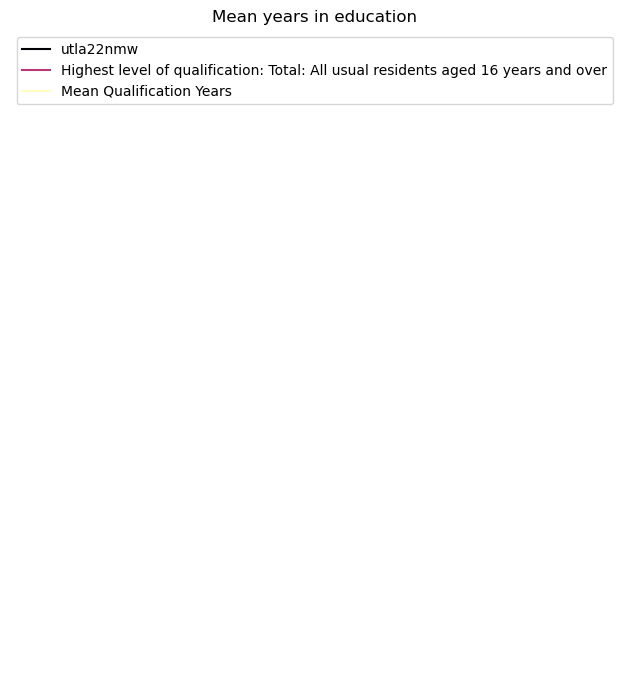

In [15]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.axis("off")
df_merged.plot(column="Mean Qualification Years", ax=ax, legend=True, cmap="magma")
ax.set_title("Mean years in education")
fig.tight_layout()
